# Nobel Model

Tasks:

1. vytvorit fiktivni populaci milionu lidi (nebo vzit CR tak, jak je) data o vekove strukture jsou na CSU

2. rozjet simulaci, ktera necha lidi umirat (asi po celych tydnech) podle umrtnostnich krivek
data jsou tady
https://www.czso.cz/…_cr
tohle by melo vytvorit casove rady, ktere jsou zde
https://www.czso.cz/…_cr

3. je treba u toho nejak vyresit ze se lidi rodi, umiraji a starnou, ale to vse je na CSU

4. az pojede tento model a bude schopen replikovat ty realne ceske krivky
tak do toho domodelovat vakcinaci
data jsou tady
prikladam txt soubor s popisem vsechn otevrenych datovych sad, ktere ma UZIS
(prehled dat UZIS.txt)

5. v kazdem tydnu je treba nahodne vytahnbout spravny pocet lidi na umrti
a spravny pocet lidi na vakcinaci

6. a ted jde o to, jestli tyhle dva vybery budou nezavisle nebo ne.
v prvni fazi to prosim udelejme nezavisle
a potom vyzkousejme postupne zvysovat miru disjunktnosti techto dvou vyberu
az do te miry, ze nikdo, kdo ma tento tyden umrit, nebude ockovan

7. no a pak uz staci nakreslit tento typ dat
https://smis-lab.cz/2022/01/01/vakcinacni-voodoo/ a tento typ dat
https://smis-lab.cz/2021/12/25/umrti-dle-ockovaciho-statutu-v-roce-2021-data-zdravotnich-pojistoven/

In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np

In [23]:
sns.set_theme()

SCALE = 10
DEBUG = False
DATA_FOLDER = "data"

## Load "Sčítání lidí"

In [24]:
dfs = pd.read_excel(f"./{DATA_FOLDER}/sldb2021_pv_vek_pohlavi.xlsx").set_index("věk")

# TODO zde to může být sumárně, bude to 4 dávky * 2 pohlaví * 20 věkových kategorií (* 51 týdnů) = 10k řádků místo 1M/10M
ages = []
genders = []

for n, row in tqdm(dfs.iterrows()):
    for m in range(row["muži"] // SCALE):
        genders.append("M")
        ages.append(n)

    for f in range(row["ženy"] // SCALE):
        genders.append("F")
        ages.append(n)

persons = pd.DataFrame({"vek": ages, "pohlavi": genders, "davek_v_tele": 0, "zestarnul": False})

101it [00:00, 1143.39it/s]


## Load deaths

In [25]:
df_deaths = pd.read_csv(f"./{DATA_FOLDER}/DEMOMIGR_2005_2021_komplet.csv")
df_deaths = df_deaths.rename(columns={"tyden": "datum", 'hodnota': 'pocet_umrti'})

# TODO We do not want other years
df_deaths = df_deaths[df_deaths["datum"].str.split("-").str[0] == "2021"]

# We do not want break out by region
df_deaths = df_deaths[df_deaths["uzemi"] == "CZ"]

# We do not want summaries "Celkem"
df_deaths = df_deaths[df_deaths["pohlavi"] != "T"]

# Converting and "normalizing"
df_deaths["datum"] = pd.to_datetime(df_deaths["datum"] + '0', format="%Y-W%W%w")
df_deaths['vekova_skupina'] = df_deaths['vek'] \
    .str.replace("_GE90", '90-120') \
    .str.replace('Y', '') \
    .str.replace('T', '-')

df_deaths["pocet_umrti"] = (df_deaths["pocet_umrti"] / SCALE).round().astype(int)
df_deaths = df_deaths.drop(columns=["vek", "uzemi"]).set_index(['datum', 'pohlavi'])

## Load vaccinations

In [26]:
df_vaccination = pd.read_csv("data/ockovani-demografie.csv")

# Converting and "normalizing"
df_vaccination["datum"] = pd.to_datetime(df_vaccination["datum"], format="%Y-%m-%d")
df_vaccination["pohlavi"] = df_vaccination["pohlavi"].replace("Z", "F")
df_vaccination["vekova_skupina"] = df_vaccination["vekova_skupina"].replace("80+", "80-100")

# Runtime optimization + date formatting
df_vaccination = df_vaccination.groupby([
    pd.Grouper(key='datum', freq='W-SUN'), "pohlavi", "vekova_skupina", "poradi_davky"]).sum().reset_index()

df_vaccination = df_vaccination.set_index(['datum', 'pohlavi'])
df_vaccination["pocet_davek"] = (df_vaccination["pocet_davek"] / SCALE).round().astype(int)

## Quick look

In [27]:
persons

,vek,pohlavi,davek_v_tele,zestarnul
0,0,M,0,False
1,0,M,0,False
2,0,M,0,False
3,0,M,0,False
4,0,M,0,False
...,...,...,...,...
1052325,100,F,0,False
1052326,100,F,0,False
1052327,100,F,0,False
1052328,100,F,0,False


In [28]:
df_deaths

pocet_umrti vekova_skupina
datum      pohlavi                            
2021-01-10 M                  0            0-4
           F                  0            0-4
           M                  0            5-9
           F                  0            5-9
           M                  0          10-14
...                         ...            ...
2021-12-26 F                 26          80-84
           M                 14          85-89
           F                 24          85-89
           M                 12         90-120
           F                 32         90-120

[1938 rows x 2 columns]

In [29]:
df_vaccination

vekova_skupina  poradi_davky  pocet_davek
datum      pohlavi                                          
2020-12-27 F                18-24             1            2
           F                25-29             1            8
           F                30-34             1            7
           F                35-39             1            8
           F                40-44             1           12
...                           ...           ...          ...
2022-10-02 M                75-79             1            0
           M                75-79             3            0
           M                75-79             4            8
           M               80-100             3            0
           M               80-100             4            6

[7621 rows x 3 columns]

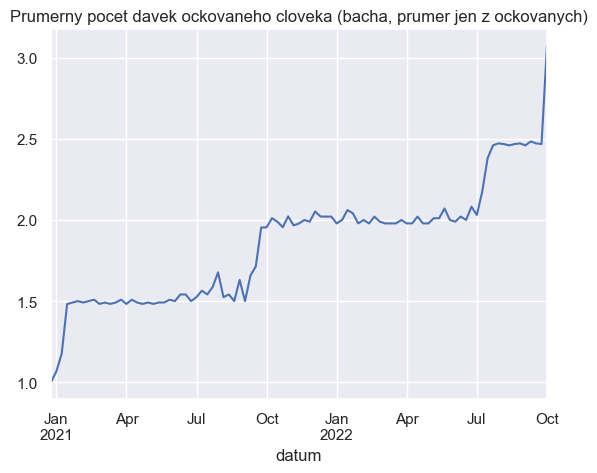

In [30]:
df_vaccination.groupby(df_vaccination.index.get_level_values('datum'))['poradi_davky'].mean().plot()
plt.title('Prumerny pocet davek ockovaneho cloveka (bacha, prumer jen z ockovanych)');

In [31]:
# df_vaccination[df_vaccination['vekova_skupina'] == '80-100'].xs('M', level=1)#.plot(y='pocet_davek')

## Model
- Pro zrychleni lze pouzivat .itertuples misto .iterrows, viz:
  - https://medium.com/swlh/why-pandas-itertuples-is-faster-than-iterrows-and-how-to-make-it-even-faster-bc50c0edd30d
- np.random.choice ma tu vyhodu, ze lze vyuzit parameter vah `p` pro pridani korelace vakcinace s umrtimi.

In [32]:
weeks = sorted(df_deaths.index.get_level_values('datum').unique())
len(weeks)

51

In [33]:
dead_vaccinated = {}
dead_normal = {}

live_vaccinated = {}
live_normal = {}

for k, week in tqdm(enumerate(weeks)):
    # -------- Mark newly vaccinated --------
    # Dva radky nize jsou super sofistikovany (a elegantni) pandas trik
    #  .groupby('poradi_davky') rozdeli tyden na casti podle sloupce `poradi_davky`
    #  nasledne iteruji pres vsechny 1. vakciny vyockovane v danem tydnu, vsechny 2., ...

    # -------- Vaccinate people --------
    grouped_vaccination_week = df_vaccination.loc[week].groupby('poradi_davky')
    for davka, vacc_week in grouped_vaccination_week:
        print(f'Zpracovavam {davka}. davku...')

        for row in vacc_week.itertuples():
            if row.pocet_davek == 0:
                continue
            age = tuple(int(a) for a in row.vekova_skupina.split("-"))
            
            # Vyberu lidi s danym pohlavim, v danem vekovem intervalu
            #  a se spravnym poctem davek (tj. ockovana davka - 1).
            cohort = persons[
                (persons["pohlavi"] == row.Index) &
                (persons["vek"] >= age[0]) &
                (persons["vek"] <= age[1]) &
                (persons["davek_v_tele"] == davka-1)
            ]

            if row.pocet_davek > len(cohort):
                print('Neco je divne, mam ockovat vice lidi nez je v dane skupine.')
                print(f"**** Je tyden {week:%Y-%m-%d} a ja ve vekove skupine {row.vekova_skupina:>6} vyberu"
                      f"{row.pocet_davek:>7,d} ockovanych z {len(cohort):>7,d} moznych")
                continue

            # Nahodne vyberu kdo bude v dane skupine vakcinovany.
            sampled_indices = cohort.sample(n=row.pocet_davek, replace=False).index
            persons.loc[sampled_indices, "davek_v_tele"] += 1

            if DEBUG:
                # Vypisu co se deje. Model ma dost pohyblivych casti.
                print(f"Je {week:%Y-%m-%d} a ve věkové skupině {row.vekova_skupina:>6} vyberu"
                      f"{row.pocet_davek:>7,d} lidí s {davka-1} dávkami z {len(cohort):>7,d} možných, "
                      f"které tento týden naočkuji.")

    # -------- Remove dead people --------
    for row in df_deaths.loc[week].itertuples():
        if row.pocet_umrti > 0:
            # TODO toto udělat jako preprocessing, zbytečně se to počítá pořád
            age = tuple(int(a) for a in row.vekova_skupina.split("-"))

            cohort = persons[
                (persons["pohlavi"] == row.Index) &
                (persons["vek"] >= age[0]) &
                (persons["vek"] <= age[1])
            ]

            if row.pocet_umrti > len(cohort):
                print('Neco je divne, ma umirat vice lidi nez je v dane skupine.')
                print(f"**** Je tyden {week:%Y-%m-%d} a ja ve vekove skupine {row.vekova_skupina:>6} umira"
                      f"{row.pocet_umrti:>7,d} lidí z {len(cohort):>7,d} moznych")
                continue

            cohort_sample = cohort.sample(n=row.pocet_umrti)

            if row.vekova_skupina not in dead_vaccinated:
                dead_vaccinated[row.vekova_skupina] = {}
                dead_normal[row.vekova_skupina] = {}
                live_vaccinated[row.vekova_skupina] = {}
                live_normal[row.vekova_skupina] = {}

            if k not in dead_vaccinated[row.vekova_skupina]:
                dead_vaccinated[row.vekova_skupina][k] = 0
                dead_normal[row.vekova_skupina][k] = 0
                live_vaccinated[row.vekova_skupina][k] = 0
                live_normal[row.vekova_skupina][k] = 0

            dead_vaccinated[row.vekova_skupina][k] += len(cohort_sample[cohort_sample["davek_v_tele"] >= 1])
            dead_normal[row.vekova_skupina][k] += len(cohort_sample[cohort_sample["davek_v_tele"] == 0])

            live_vaccinated[row.vekova_skupina][k] += len(cohort[cohort["davek_v_tele"] >= 1])
            live_normal[row.vekova_skupina][k] += len(cohort[cohort["davek_v_tele"] == 0])

            persons.drop(cohort_sample.index, inplace=True)

            if DEBUG:
                # Vypisu co se deje. Model ma dost pohyblivych casti.
                print(f"Je {week:%Y-%m-%d} a ve věkové skupině {row.vekova_skupina:>6} umírá"
                      f"{row.pocet_umrti:>7,d} lidí z {len(cohort):>7,d} možných")

    # -------- Make people older --------
    # TODO nebude fungovat pokud budeme iterovat přes více let
    # TODO předpoklad uniformního narození - lze někdy najít, kolik lidí se narodilo v jeden den?
    na_zestarnuti = persons[persons["zestarnul"] == False].sample(round(len(persons) * 7 / 365)).index
    persons.loc[persons.index.isin(na_zestarnuti), "vek"] = persons.loc[persons.index.isin(na_zestarnuti), "vek"] + 1
    persons.loc[persons.index.isin(na_zestarnuti), "zestarnul"] = True

    # TODO: Odstranit, jen pro debug.
    if k >= 51:
        break

0it [00:00, ?it/s]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


1it [00:02,  2.80s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


2it [00:06,  3.19s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


3it [00:09,  3.41s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


4it [00:13,  3.55s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


5it [00:17,  3.52s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


6it [00:20,  3.55s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


7it [00:24,  3.57s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


8it [00:28,  3.63s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


9it [00:31,  3.60s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


10it [00:35,  3.67s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


11it [00:39,  3.68s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


12it [00:42,  3.66s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


13it [00:46,  3.70s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


14it [00:50,  3.68s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


15it [00:53,  3.66s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


16it [00:57,  3.65s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


17it [01:01,  3.67s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


18it [01:04,  3.67s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


19it [01:08,  3.67s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


20it [01:12,  3.67s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


21it [01:15,  3.65s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


22it [01:19,  3.68s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 4. davku...


23it [01:23,  3.70s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 4. davku...


24it [01:27,  3.70s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


25it [01:30,  3.66s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


26it [01:35,  3.89s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


27it [01:38,  3.89s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 4. davku...


28it [01:42,  3.82s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


29it [01:46,  3.80s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


30it [01:50,  3.81s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


31it [01:53,  3.76s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 4. davku...


32it [01:57,  3.78s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


33it [02:01,  3.84s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


34it [02:05,  3.84s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...


35it [02:09,  3.78s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


36it [02:12,  3.78s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


37it [02:16,  3.75s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


38it [02:21,  3.99s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


39it [02:25,  4.20s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


40it [02:30,  4.32s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


41it [02:34,  4.34s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


42it [02:39,  4.45s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


43it [02:44,  4.60s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


44it [02:49,  4.65s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


45it [02:53,  4.66s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...


46it [02:58,  4.67s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


47it [03:03,  4.70s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


48it [03:08,  4.74s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


49it [03:13,  4.79s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


50it [03:17,  4.82s/it]

Zpracovavam 1. davku...
Zpracovavam 2. davku...
Zpracovavam 3. davku...
Zpracovavam 4. davku...


51it [03:22,  3.98s/it]


## Visualizations

### https://smis-lab.cz/2022/01/01/vakcinacni-voodoo/

In [19]:
dead_vaccinated_total = [0 for _ in range(len(weeks))]
dead_normal_total = [0 for _ in range(len(weeks))]

for w in dead_vaccinated.values():
    for k, v in w.items():
        dead_vaccinated_total[k] += v

for w in dead_normal.values():
    for k, v in w.items():
        dead_normal_total[k] += v

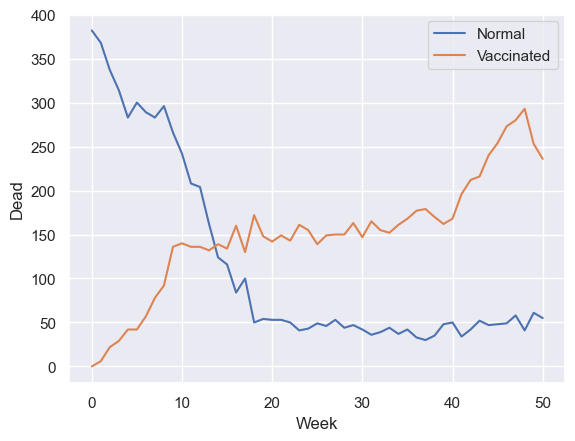

In [20]:
plt.plot(dead_normal_total, label="Normal")
plt.plot(dead_vaccinated_total, label="Vaccinated")
plt.ylabel("Dead")
plt.xlabel("Week")
plt.legend();

In [21]:
dead_vaccinated.keys()

dict_keys(['35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-120', '25-29', '30-34'])

In [48]:
SELECTED_CATEGORY = "85-89"
SELECTED_CATEGORIES = ['80-84', '85-89', '90-120']

In [37]:
dead_vaccinated[SELECTED_CATEGORY].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [83]:
sum(sum(dead_normal[i].values()) for i in dead_normal)

5924

In [81]:
sum(sum(dead_vaccinated[i].values()) for i in dead_vaccinated)

7629

In [76]:
x = sorted(list(set([int(str(w).split("-")[1]) for w in weeks])))
y_vacc = [0 for _ in x]
y_normal = [0 for _ in x]

for i in dead_vaccinated:
    if i not in SELECTED_CATEGORIES:
        continue

    for j in dead_vaccinated[i]:
        y_vacc[int(str(weeks[j]).split("-")[1]) - 1] += dead_vaccinated[i][j]

    for j in dead_normal[i]:
        y_normal[int(str(weeks[j]).split("-")[1]) - 1] += dead_normal[i][j]

In [78]:
y_normal

[620, 387, 263, 140, 97, 76, 76, 81, 62, 95, 103, 93]

In [54]:
from matplotlib.dates import date2num

x = date2num(x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


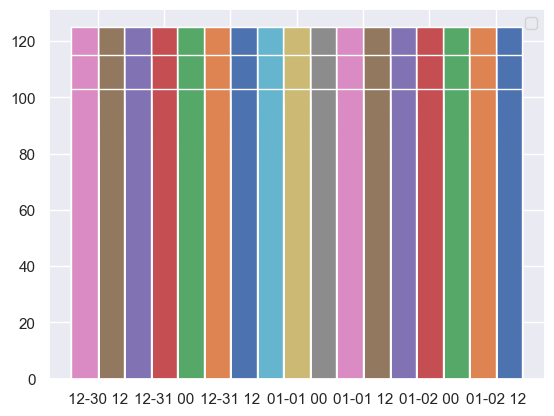

In [57]:
import datetime


x = date2num(x)

ax = plt.subplot(111)
for n, k in enumerate(sorted(dead_vaccinated.keys())):
    ax.bar(x + 0.2*(len(dead_vaccinated) // 2 - n), y_vacc, width=0.2, align='center')

ax.xaxis_date()

plt.legend()
plt.show()

In [20]:
for k in dead_vaccinated:
    print(k, len(dead_vaccinated[k]))

35-39 4
40-44 4
45-49 4
50-54 4
55-59 4
60-64 4
65-69 4
70-74 4
75-79 4
80-84 4
85-89 4
90-120 4
25-29 2
30-34 3


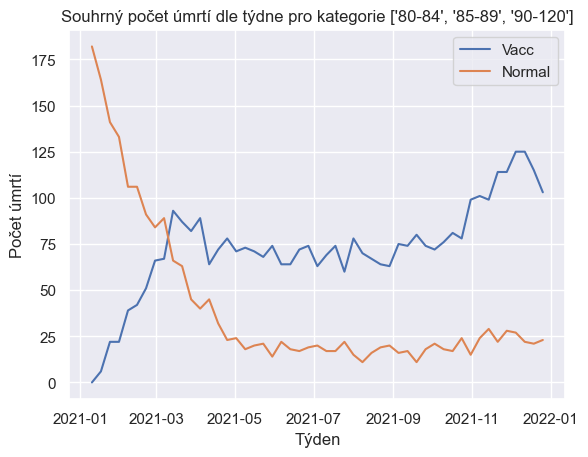

In [49]:
#plt.plot(dead_vaccinated[SELECTED_CATEGORY].keys(), dead_vaccinated[SELECTED_CATEGORY].values(), label="Vaccinated")
#plt.plot(dead_normal[SELECTED_CATEGORY].keys(), dead_normal[SELECTED_CATEGORY].values(), label="Normal")
plt.plot(x, y_vacc, label="Vacc")
plt.plot(x, y_normal, label="Normal")
plt.xlabel("Týden")
plt.ylabel("Počet úmrtí")
plt.title(f"Souhrný počet úmrtí dle týdne pro kategorie {SELECTED_CATEGORIES}")
plt.legend();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


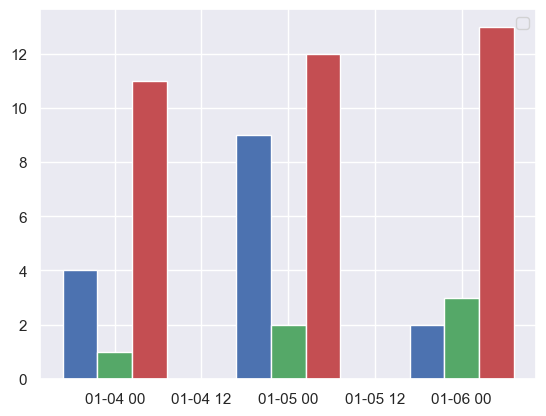